In [1]:
##################################################################################
#                                                                                #
#                                Comparison Notebook                             #
#                                                                                #
##################################################################################

In [2]:
# =====================
# Imports
# =====================
# %load_ext line_profiler
import sys
sys.path.append('..')
sys.path.append('mister_ed') # library for adversarial examples
sys.path.append('CertifiedReLURobustness')
from collections import defaultdict
import geocert_oop as geo
from domains import Domain
from plnn import PLNN
import _polytope_ as _poly_
from _polytope_ import Polytope, Face
import utilities as utils
import os
import time 
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from cvxopt import solvers, matrix
import adversarial_perturbations as ap 
import prebuilt_loss_functions as plf
import loss_functions as lf 
import adversarial_attacks as aa
import utils.pytorch_utils as me_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import mnist.mnist_loader as  ml 
MNIST_DIM = 784

/home/justin/.conda/envs/DeepL/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [3]:
# Define functions to train and evaluate a network 

def l1_loss(net):
    return sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])

def l2_loss(net):
    return sum([_.norm(p=2) for _ in net.parameters() if _.dim() > 1])
  
    
def train(net, trainset, num_epochs):
    opt = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0)
    for epoch in range(num_epochs):
        err_acc = 0
        err_count = 0
        for data, labels in trainset:
            output = net(Variable(data.view(-1, 784)))
            l = nn.CrossEntropyLoss()(output, Variable(labels)).view([1])
            l1_scale = torch.Tensor([2e-3])
            l += l1_scale * l1_loss(net).view([1])
            
            err_acc += (output.max(1)[1].data != labels).float().mean() 
            err_count += 1
            opt.zero_grad() 
            (l).backward() 
            opt.step() 
        print("(%02d) error:" % epoch, err_acc / err_count)
            
        
def test_acc(net, valset):
    err_acc = 0 
    err_count = 0 
    for data, labels in valset:
        n = data.shape[0]
        output = net(Variable(data.view(-1, 784)))
        err_acc += (output.max(1)[1].data != labels).float().mean() * n
        err_count += n
        
    print("Accuracy of: %.03f" % (1 - (err_acc / err_count).item()))

In [4]:
##################################################################################
#                                                                                #
#                       Network Model + Data Loading                             #
#                                                                                #
##################################################################################

ALL_DIGITS = True 
lp_norm = 'l_2'
train_network = False

if not ALL_DIGITS:
    digits = [1, 7]
    trainset = ml.load_single_digits('train', digits, batch_size=16, 
                                      shuffle=False)  
    valset = ml.load_single_digits('val', digits, batch_size=16, 
                                      shuffle=False)
    NETWORK_NAME = '17_mnist_small.pkl'
    layer_sizes = [MNIST_DIM, 10, 50, 10, len(digits)]
    if lp_norm == 'l_inf':
        pgd_lr = 0.01
    elif lp_norm == 'l_2':
        pgd_lr = 0.005
    num_epochs = 50
    num_pgd_iterations = 300
else:    
    trainset = ml.load_mnist_data('train', batch_size=16, shuffle=False)
    valset = ml.load_mnist_data('val', batch_size=16, shuffle=False)
    NETWORK_NAME = 'mnist_small.pkl'
    layer_sizes = [MNIST_DIM, 10, 50, 10, 10]
    num_pgd_iterations = 300
    if lp_norm == 'l_inf':
        pgd_lr = 0.01
    elif lp_norm == 'l_2':
        pgd_lr = 0.005
    num_epochs = 100


if train_network:
    
    print("Training a new network")
    network = PLNN(layer_sizes)
    net = network.net
    train(net, trainset, num_epochs)
    pickle.dump(network, open(NETWORK_NAME, 'wb'))
else:    
    network = pickle.load(open(NETWORK_NAME, 'rb'))
    net = network.net
    print("Loaded pretrained network")


    
test_acc(net, valset)    

Loaded pretrained network
Accuracy of: 0.886


In [5]:
# =====================
# Set Images to Verify
# =====================
num_batches = len(valset)
num_batches = 1

if not ALL_DIGITS:
    images = torch.cat([batch_tuple[0] for batch_tuple in valset[0:num_batches]])
    labels = torch.cat([batch_tuple[1] for batch_tuple in valset[0:num_batches]])
else:
    images = torch.cat([next(iter(valset))[0] for _ in range(0, num_batches)])
    labels = torch.cat([next(iter(valset))[1] for _ in range(0, num_batches)])
    
print('Num Images:', len(images))

Num Images: 16


In [6]:
# ##################################################################################
# #                                                                                #
# #                       Geocert                                                  #
# #                                                                                #
# ##################################################################################



# # Run Geocert on a set of mnist digits
# min_dists = []
# pgd_dists = []
# num_polys = []
# poly_maps = []
# times = []
# for image in images:
#         # Builds an object used to to hold algorithm parameters
#         cert_obj = geo.IncrementalGeoCert(network, verbose=True, config_fxn='parallel', 
#                                   config_fxn_kwargs={'num_jobs': 1},
#                                   hyperbox_bounds=[0.0, 1.0])
    
#         plt.gray()
#         plt.imshow(image.squeeze())
#         plt.show()
#         true_label = network(image).squeeze().max(0)[1].item()
#         # Run Geocert 
#         start = time.time()
#         output = cert_obj.min_dist(image.view(1, -1), lp_norm=lp_norm, compute_upper_bound=
#                                    {"optimizer_kwargs": {"lr": pgd_lr}, "num_iterations": num_pgd_iterations})
#         lp_dist, adv_ex_bound, adv_ex, best_example, boundary_facet, seen_poly_map = output
#         end = time.time()
#         plt.gray()
#         best_example_np = utils.as_numpy(best_example).reshape(28,28)
#         plt.imshow(best_example_np.squeeze())
#         plt.show()
        
#         min_dists.append(lp_dist)
#         pgd_dists.append(adv_ex_bound)
#         print('TIME', end-start)
#         times.append(end-start)
#         num_polys.append(len(seen_poly_map))
#         poly_maps.append(seen_poly_map)
#         print('===========================================')

In [7]:
# # =====================
# # Save Output
# # =====================

# output_dictionary = {'min_dists': min_dists , 'pgd_dists': pgd_dists, 'num_polys': num_polys,
#                     'poly_maps': [list(_) for _ in poly_maps], 'times': times}

# cwd = os.getcwd()
# filename = cwd + "/Results/Geocert_out_"+str(NETWORK_NAME[0:-4])+"_"+lp_norm+".pkl"
# f = open(filename, 'wb')
# pickle.dump(output_dictionary, f)
# f.close()

In [8]:
# =====================
# Load and Display Output
# =====================

cwd = os.getcwd()
filename = cwd + "/Results/Geocert_out_"+str(NETWORK_NAME[0:-4])+"_"+lp_norm+".pkl"
f = open(filename,"rb")
output_dict = pickle.load(f)
f.close()

def mean(elements):
    return sum(elements) / float(len(elements))

def percentile(elements, perc=50):
    perc_idx = int(len(elements) * perc / 100.0)
    return sorted(elements)[perc_idx]


for k, v in output_dict.items():
    if k not in ['min_dists', 'pgd_dists', 'num_polys', 'times']:
        continue
    print('-' * 20, k, '-' * 20)
    print('MEAN   ', mean(v))
    print('25th   ', percentile(v, 25))
    print('MEDIAN ', percentile(v, 50))
    print('90     ', percentile(v, 90))
    print('\n')

-------------------- min_dists --------------------
MEAN    0.7789839023442325
25th    0.4863299904222928
MEDIAN  0.8427527557551817
90      1.5261259580318753


-------------------- pgd_dists --------------------
MEAN    2.064432650284531
25th    1.5689817667007446
MEDIAN  1.983636498451233
90      3.7796852588653564


-------------------- num_polys --------------------
MEAN    33.5625
25th    11
MEDIAN  28
90      92


-------------------- times --------------------
MEAN    20.98907183210055
25th    4.1127214431762695
MEDIAN  15.240533351898193
90      53.284825801849365




In [9]:
##################################################################################
#                                                                                #
#                       Fast Lin / Fast Lip                                      #
#                                                                                #
##################################################################################



/home/justin/.conda/envs/DeepL/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Instructions for updating:
Colocations handled automatically by placer.
Hidden layer 0 weight shape: (784, 10)
Hidden layer 0 bias shape: (10,)
Hidden layer 1 weight shape: (10, 50)
Hidden layer 1 bias shape: (50,)
Hidden layer 2 weight shape: (50, 10)
Hidden layer 2 bias shape: (10,)
Last layer weight shape: (10, 10)
Last layer bias shape: (10,)
warming up...
layer 0 3 neurons never activated, 7 neurons always activated
layer 1 40 neurons never activated, 10 neurons always activated
layer 2 2 neurons never activated, 8 neurons always activated
epsilon = 0.01000
    8.29 < f_c - f_1 < 8.51
    -0.10 < f_c - f_2 < 0.09
    -1.28 < f_c - f_3 < -1.02
    7.52 < f_c - f_4 < 7.78
    0.79 < f_c - f_5 < 1.02
    11.59 < f_c - f_6 < 11.91
    -8.78 < f_c - f_7 < -8.56
    4.07 < f_c - f_8 < 4.20
    -1.79 < f_c - f_9 < -1.52
starting robustness verification on 16 images!
layer 0 3 neurons never activated, 5 neurons always activated
layer 1 40 neurons never activated, 10 neurons always activat

layer 0 2 neurons never activated, 8 neurons always activated
layer 1 40 neurons never activated, 10 neurons always activated
layer 2 4 neurons never activated, 6 neurons always activated
epsilon = 0.00430
    12.42 < f_c - f_0 < 12.48
    6.68 < f_c - f_2 < 6.78
    6.02 < f_c - f_3 < 6.11
    6.51 < f_c - f_4 < 6.58
    8.10 < f_c - f_5 < 8.15
    14.49 < f_c - f_6 < 14.69
    5.71 < f_c - f_7 < 5.77
    7.12 < f_c - f_8 < 7.16
    8.15 < f_c - f_9 < 8.21
[L2][binary search] step = 0, eps = 0.00430, gap_gx = 5.71
layer 0 2 neurons never activated, 7 neurons always activated
layer 1 40 neurons never activated, 9 neurons always activated
layer 2 4 neurons never activated, 6 neurons always activated
epsilon = 0.04302
    12.13 < f_c - f_0 < 12.76
    6.26 < f_c - f_2 < 7.19
    5.63 < f_c - f_3 < 6.49
    6.19 < f_c - f_4 < 6.97
    7.88 < f_c - f_5 < 8.37
    13.59 < f_c - f_6 < 15.59
    5.38 < f_c - f_7 < 6.07
    6.93 < f_c - f_8 < 7.33
    7.85 < f_c - f_9 < 8.50
[L2][binary search

layer 0 3 neurons never activated, 5 neurons always activated
layer 1 40 neurons never activated, 7 neurons always activated
layer 2 2 neurons never activated, 3 neurons always activated
epsilon = 1.03943
    -5.32 < f_c - f_0 < 15.32
    1.14 < f_c - f_1 < 23.05
    -10.41 < f_c - f_2 < 16.33
    -8.44 < f_c - f_3 < 18.99
    -5.47 < f_c - f_5 < 10.82
    -1.24 < f_c - f_6 < 15.82
    -8.47 < f_c - f_7 < 15.90
    -4.14 < f_c - f_8 < 15.62
    -4.97 < f_c - f_9 < 9.34
[L2][binary search] step = 0, eps = 1.03943, gap_gx = -10.41
layer 0 3 neurons never activated, 5 neurons always activated
layer 1 40 neurons never activated, 8 neurons always activated
layer 2 2 neurons never activated, 3 neurons always activated
epsilon = 0.51972
    2.45 < f_c - f_0 < 12.19
    9.03 < f_c - f_1 < 19.43
    1.44 < f_c - f_2 < 11.66
    2.16 < f_c - f_3 < 14.23
    0.37 < f_c - f_5 < 8.25
    4.44 < f_c - f_6 < 12.51
    0.94 < f_c - f_7 < 11.27
    2.87 < f_c - f_8 < 12.05
    -0.59 < f_c - f_9 < 6.15


layer 0 2 neurons never activated, 5 neurons always activated
layer 1 40 neurons never activated, 8 neurons always activated
layer 2 3 neurons never activated, 6 neurons always activated
epsilon = 0.40230
    9.96 < f_c - f_0 < 17.37
    2.66 < f_c - f_2 < 13.18
    0.06 < f_c - f_3 < 9.05
    3.07 < f_c - f_4 < 11.57
    5.61 < f_c - f_5 < 11.94
    9.32 < f_c - f_6 < 29.81
    1.00 < f_c - f_7 < 8.48
    4.39 < f_c - f_8 < 9.89
    2.82 < f_c - f_9 < 10.90
[L2][binary search] step = 6, eps = 0.40230, gap_gx = 0.06
layer 0 2 neurons never activated, 5 neurons always activated
layer 1 40 neurons never activated, 8 neurons always activated
layer 2 3 neurons never activated, 6 neurons always activated
epsilon = 0.40583
    9.92 < f_c - f_0 < 17.40
    2.60 < f_c - f_2 < 13.22
    -0.00 < f_c - f_3 < 9.08
    3.02 < f_c - f_4 < 11.61
    5.57 < f_c - f_5 < 11.96
    9.23 < f_c - f_6 < 29.90
    0.96 < f_c - f_7 < 8.51
    4.35 < f_c - f_8 < 9.91
    2.77 < f_c - f_9 < 10.93
[L2][binary se

layer 0 3 neurons never activated, 6 neurons always activated
layer 1 40 neurons never activated, 9 neurons always activated
layer 2 3 neurons never activated, 6 neurons always activated
epsilon = 0.48467
    6.49 < f_c - f_0 < 18.86
    1.11 < f_c - f_1 < 9.16
    4.53 < f_c - f_2 < 16.74
    1.53 < f_c - f_3 < 6.70
    -0.92 < f_c - f_4 < 4.87
    1.28 < f_c - f_5 < 7.60
    7.84 < f_c - f_6 < 34.58
    1.04 < f_c - f_7 < 7.05
    1.14 < f_c - f_8 < 9.84
[L2][binary search] step = 0, eps = 0.48467, gap_gx = -0.92
layer 0 3 neurons never activated, 7 neurons always activated
layer 1 41 neurons never activated, 9 neurons always activated
layer 2 4 neurons never activated, 6 neurons always activated
epsilon = 0.24233
    9.76 < f_c - f_0 < 15.68
    3.33 < f_c - f_1 < 7.05
    8.14 < f_c - f_2 < 13.45
    3.06 < f_c - f_3 < 5.28
    0.65 < f_c - f_4 < 3.39
    3.01 < f_c - f_5 < 5.97
    14.68 < f_c - f_6 < 27.83
    2.94 < f_c - f_7 < 5.38
    3.37 < f_c - f_8 < 7.64
[L2][binary search

layer 1 41 neurons never activated, 9 neurons always activated
layer 2 6 neurons never activated, 4 neurons always activated
epsilon = 0.00279
    5.75 < f_c - f_0 < 5.77
    13.59 < f_c - f_1 < 13.62
    4.30 < f_c - f_2 < 4.32
    7.14 < f_c - f_3 < 7.16
    -0.71 < f_c - f_4 < -0.68
    5.87 < f_c - f_6 < 5.91
    12.42 < f_c - f_7 < 12.45
    2.93 < f_c - f_8 < 2.94
    3.76 < f_c - f_9 < 3.79
[L2][binary search] step = 7, eps = 0.00279, gap_gx = -0.71
layer 0 4 neurons never activated, 6 neurons always activated
layer 1 41 neurons never activated, 9 neurons always activated
layer 2 6 neurons never activated, 4 neurons always activated
epsilon = 0.00139
    5.76 < f_c - f_0 < 5.77
    13.60 < f_c - f_1 < 13.61
    4.31 < f_c - f_2 < 4.32
    7.14 < f_c - f_3 < 7.15
    -0.71 < f_c - f_4 < -0.69
    5.88 < f_c - f_6 < 5.90
    12.42 < f_c - f_7 < 12.44
    2.93 < f_c - f_8 < 2.94
    3.77 < f_c - f_9 < 3.79
[L2][binary search] step = 8, eps = 0.00139, gap_gx = -0.71
layer 0 4 neuron

layer 0 2 neurons never activated, 5 neurons always activated
layer 1 40 neurons never activated, 7 neurons always activated
layer 2 3 neurons never activated, 5 neurons always activated
epsilon = 0.64495
    12.91 < f_c - f_1 < 24.03
    -0.25 < f_c - f_2 < 10.54
    -2.36 < f_c - f_3 < 12.73
    10.29 < f_c - f_4 < 25.65
    -0.69 < f_c - f_5 < 8.67
    4.05 < f_c - f_6 < 17.98
    7.32 < f_c - f_7 < 19.98
    2.15 < f_c - f_8 < 9.50
    6.04 < f_c - f_9 < 17.71
[L2][binary search] step = 0, eps = 0.64495, gap_gx = -2.36
layer 0 3 neurons never activated, 7 neurons always activated
layer 1 41 neurons never activated, 9 neurons always activated
layer 2 3 neurons never activated, 6 neurons always activated
epsilon = 0.32247
    16.57 < f_c - f_1 < 21.01
    4.04 < f_c - f_2 < 8.26
    2.97 < f_c - f_3 < 8.80
    15.23 < f_c - f_4 < 21.19
    2.81 < f_c - f_5 < 5.85
    8.42 < f_c - f_6 < 12.96
    11.95 < f_c - f_7 < 16.70
    4.34 < f_c - f_8 < 7.37
    9.99 < f_c - f_9 < 13.89
[L2][b

layer 0 3 neurons never activated, 5 neurons always activated
layer 1 41 neurons never activated, 8 neurons always activated
layer 2 3 neurons never activated, 6 neurons always activated
epsilon = 0.24649
    6.41 < f_c - f_0 < 11.99
    14.10 < f_c - f_1 < 18.21
    6.78 < f_c - f_2 < 11.57
    6.34 < f_c - f_3 < 8.35
    2.26 < f_c - f_4 < 5.10
    4.67 < f_c - f_5 < 7.22
    9.62 < f_c - f_6 < 20.78
    2.80 < f_c - f_7 < 5.57
    4.39 < f_c - f_8 < 8.33
[L2][binary search] step = 0, eps = 0.24649, gap_gx = 2.26
layer 0 2 neurons never activated, 4 neurons always activated
layer 1 40 neurons never activated, 4 neurons always activated
layer 2 2 neurons never activated, 1 neurons always activated
epsilon = 2.46490
    -23.51 < f_c - f_0 < 42.22
    -13.36 < f_c - f_1 < 39.97
    -33.47 < f_c - f_2 < 44.48
    -22.66 < f_c - f_3 < 24.11
    -16.54 < f_c - f_4 < 22.85
    -15.70 < f_c - f_5 < 17.86
    -31.47 < f_c - f_6 < 87.21
    -23.21 < f_c - f_7 < 27.05
    -14.63 < f_c - f_8 < 2

layer 0 3 neurons never activated, 5 neurons always activated
layer 1 41 neurons never activated, 8 neurons always activated
layer 2 3 neurons never activated, 6 neurons always activated
epsilon = 0.80295
    18.25 < f_c - f_1 < 29.81
    5.10 < f_c - f_2 < 12.33
    3.77 < f_c - f_3 < 14.31
    9.73 < f_c - f_4 < 24.96
    1.92 < f_c - f_5 < 9.51
    7.66 < f_c - f_6 < 19.14
    5.01 < f_c - f_7 < 16.67
    4.05 < f_c - f_8 < 10.65
    3.97 < f_c - f_9 < 13.71
[L2][binary search] step = 6, eps = 0.80295, gap_gx = 1.92
layer 0 2 neurons never activated, 5 neurons always activated
layer 1 40 neurons never activated, 8 neurons always activated
layer 2 3 neurons never activated, 6 neurons always activated
epsilon = 0.89108
    17.25 < f_c - f_1 < 30.62
    4.00 < f_c - f_2 < 12.89
    2.35 < f_c - f_3 < 15.24
    8.51 < f_c - f_4 < 26.18
    1.03 < f_c - f_5 < 10.27
    6.48 < f_c - f_6 < 20.38
    3.81 < f_c - f_7 < 17.60
    3.44 < f_c - f_8 < 11.15
    2.92 < f_c - f_9 < 14.72
[L2][bin

layer 0 2 neurons never activated, 6 neurons always activated
layer 1 40 neurons never activated, 7 neurons always activated
layer 2 3 neurons never activated, 6 neurons always activated
epsilon = 0.34066
    11.74 < f_c - f_0 < 17.24
    5.64 < f_c - f_2 < 13.60
    0.01 < f_c - f_3 < 7.49
    5.87 < f_c - f_4 < 12.47
    6.84 < f_c - f_5 < 11.36
    13.76 < f_c - f_6 < 30.19
    4.47 < f_c - f_7 < 10.35
    5.20 < f_c - f_8 < 9.11
    4.86 < f_c - f_9 < 10.84
[L2][binary search] step = 11, eps = 0.34066, gap_gx = 0.01
[L1] seq = 14, id = 14, true_class = 1, target_class = 1 robustness_gx = 0.34066, avg_robustness_gx = 0.47070, time = 0.0428, total_time = 0.6580
layer 0 2 neurons never activated, 8 neurons always activated
layer 1 41 neurons never activated, 9 neurons always activated
layer 2 2 neurons never activated, 6 neurons always activated
epsilon = 0.34066
    6.72 < f_c - f_0 < 15.13
    5.67 < f_c - f_1 < 10.44
    8.22 < f_c - f_2 < 16.82
    -0.59 < f_c - f_3 < 6.84
    12.

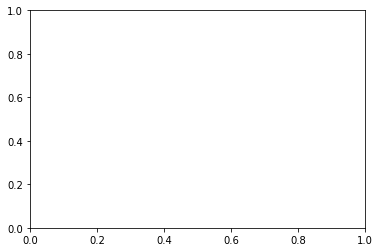

In [10]:
# =====================
# Run Fast Lin / Fast LIP
# =====================
from CertifiedReLURobustness.Lip_Lin_verify import Lin_Lip_verify_modded

dists, times = Lin_Lip_verify_modded(network, NETWORK_NAME, images, labels)

In [11]:
# =====================
# Load and Display Output
# =====================

cwd = os.getcwd()
filename = cwd + "/Results/Lip_Lin_" + str(NETWORK_NAME[0:-4]) + "_norm_" + '2' + ".pkl"
f = open(filename,"rb")
output_dict = pickle.load(f)
f.close()

def mean(elements):
    return sum(elements) / float(len(elements))

def percentile(elements, perc=50):
    perc_idx = int(len(elements) * perc / 100.0)
    return sorted(elements)[perc_idx]


for k, v in output_dict.items():
    if k not in ['min_dists', 'pgd_dists', 'num_polys', 'times']:
        continue
    print('-' * 20, k, '-' * 20)
    print('MEAN   ', mean(v))
    print('25th   ', percentile(v, 25))
    print('MEDIAN ', percentile(v, 50))
    print('90     ', percentile(v, 90))
    print('\n')

-------------------- min_dists --------------------
MEAN    0.4594083527680351
25th    0.3406620368733097
MEDIAN  0.4517075175999531
90      0.975770421701452


-------------------- times --------------------
MEAN    0.04143877327442169
25th    0.035079002380371094
MEDIAN  0.04218554496765137
90      0.05238485336303711


